In [1]:
import warnings
warnings.filterwarnings("ignore") # ignore convergence warnings

# Data downloader
from sklearn.datasets import fetch_openml

# Standard Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Metrics and model selection
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split

# ML Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier

from feature_engine.imputation import MeanMedianImputer
from feature_engine.imputation import CategoricalImputer
from feature_engine.encoding import OneHotEncoder
from feature_engine.wrappers import SklearnTransformerWrapper


from boruta import BorutaPy
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)


sns.set_style('white')
%matplotlib inline

In [2]:
# Ver Python/Mestrado/Aprendizado-de-Maquina/Projeto_Final_v2-Copy1.ipynb

In [3]:
# Dataset details at- https://www.openml.org/d/40945
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
y = y.astype('int')
df = pd.merge(X, y, left_index=True, right_index=True)

In [4]:
df.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,survived
0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO",1
1,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON",1
2,1.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON",0
3,1.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,135.0,"Montreal, PQ / Chesterville, ON",0
4,1.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON",0


# FUNÇÕES DE VISUALIZAÇÃO E TRATAMENTO DE DADOS

In [5]:
def trata_colunas_object(dataframe):
    """Analisa as colunas de um dataframe com o tipo de dado Object
        e performa uma mudança automática para o tipo de dado adequado"""
    
    memoria_inicio = dataframe.memory_usage().sum()
    
    for col in dataframe.select_dtypes('object').columns:
        
        unicos = dataframe[col].nunique()
        try:
            if dataframe[col].iloc[0].isnumeric():
                # É uma string feita por números
                try:
                    dataframe[col] = dataframe[col].astype('float32')
                    print(f'Coluna "{col}" transformada para o tipo de dado "float32"')
                except Exception as error:
                    print(f'Erro na coluna "{col}". Erro: "{error}"')
            else:
                # É uma string com letras
                # Verifica a proporção de valores únicos na coluna
                if unicos < 30:
                    dataframe[col] = dataframe[col].astype('category')
                    print(f'Coluna "{col}" transformada para o tipo de dado "category"')
                else:
                    print(f'A coluna "{col}" apresenta muitos valores do tipo Object diferentes, verificar se é válido transformar em Category')
        except AttributeError:
            # Não é uma string
                try:
                    dataframe[col] = dataframe[col].astype('float32')
                    print(f'Coluna "{col}" transformada para o tipo de dado "float32"')
                except Exception as error:
                    print(f'Erro na coluna "{col}". Erro: "{error}"')
    
    memoria_final = dataframe.memory_usage().sum()
    
    print(f'Memória economizada após as mudanças = {memoria_inicio - memoria_final} MB')

In [6]:
def analisa_valores_nan(dataframe):
    """Faz uma análise rápida sobre os dados np.nan do dataframe"""
    
    print(f'Total de dados faltantes do dataset: {dataframe.isna().sum().sum()}')
    print(f'Quantidade de dados no dataset: {dataframe.size}')
    print(f'Representatividade dos faltantes: {round(dataframe.isna().sum().sum() / dataframe.size * 100, 4)}%')
    print(f'Proporção de linhas que contém ao menos 1 NaN no Dataset: {round(dataframe[dataframe.isna().any(1)].shape[0] / dataframe.shape[0] * 100, 4)}%')
    
    print()
    print('Proporção de valores faltantes por variável:')
    display((dataframe.isna().sum()[dataframe.isna().sum() > 0] / dataframe.shape[0]).to_frame().sort_values(0, ascending=False))

In [7]:
def plota_ditribuicao_target(dataframe, target):
    
    unicos = dataframe[target].nunique()
    
    if unicos > 20:
        sns.histplot(dataframe[target], kde=True, stat='count', bins='auto')
    else:
        valores = dataframe[target].value_counts(normalize=True)
        plt.pie(
            valores,
            labels=valores.index,
            colors= sns.color_palette('pastel')[:len(valores.index)],
            autopct='%.2f%%',
            textprops={'fontsize': 14}
            )
        
    plt.show()

In [8]:
def maiores_correlacoes(dataframe, threshold=0.8):

    correlacoes = (
        pd.DataFrame(
            dataframe.corr()[(dataframe.corr().abs() > threshold) & (dataframe.corr() < 1)] # tiramos o 1 para ignorar a correlação com si mesma
                     .unstack()
                     .dropna()
                     )
        .reset_index()
        .rename(columns={'level_0':'Variável 1', 'level_1':'Variável 2', 0:'Correlação'})
    )
    correlacoes.sort_values(by='Correlação', ascending=False, inplace=True)
    correlacoes.drop_duplicates(subset=['Correlação'], inplace=True)
    
    display(correlacoes)
    print(f'Existem {correlacoes.shape[0]} variáveis com a correlação absoluta maior que {threshold}')

In [9]:
trata_colunas_object(X)

A coluna "name" apresenta muitos valores do tipo Object diferentes, verificar se é válido transformar em Category
Erro na coluna "ticket". Erro: "could not convert string to float: 'PC 17609'"
A coluna "cabin" apresenta muitos valores do tipo Object diferentes, verificar se é válido transformar em Category
Erro na coluna "boat". Erro: "could not convert string to float: 'D'"
A coluna "home.dest" apresenta muitos valores do tipo Object diferentes, verificar se é válido transformar em Category
Memória economizada após as mudanças = 0 MB


In [10]:
analisa_valores_nan(X)

Total de dados faltantes do dataset: 3855
Quantidade de dados no dataset: 17017
Representatividade dos faltantes: 22.6538%
Proporção de linhas que contém ao menos 1 NaN no Dataset: 100.0%

Proporção de valores faltantes por variável:


,0
body,0.907563
cabin,0.774637
boat,0.628724
home.dest,0.430863
age,0.200917
embarked,0.001528
fare,0.000764


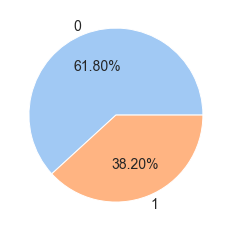

In [11]:
plota_ditribuicao_target(df, 'survived')

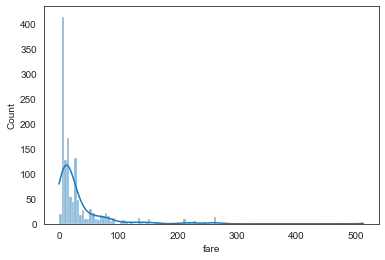

In [12]:
plota_ditribuicao_target(df, 'fare')

In [13]:
maiores_correlacoes(X, threshold=0.3)

,Variável 1,Variável 2,Correlação
3,sibsp,parch,0.373587
0,pclass,age,-0.408106
1,pclass,fare,-0.558629


Existem 3 variáveis com a correlação absoluta maior que 0.3


In [14]:
X = X.drop(['name', 'home.dest', 'ticket', 'cabin', 'body'], axis=1)
X['boat'] = np.where(X['boat'] != None, 1, 0)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [16]:
X_train

,pclass,sex,age,sibsp,parch,fare,embarked,boat
680,3.0,male,NaN,0.0,0.0,7.2250,C,1
390,2.0,male,17.0,0.0,0.0,73.5000,S,1
204,1.0,female,NaN,1.0,0.0,82.1708,C,1
465,2.0,female,23.0,0.0,0.0,13.7917,C,1
513,2.0,female,14.0,1.0,0.0,30.0708,C,1
...,...,...,...,...,...,...,...,...
123,1.0,male,60.0,1.0,1.0,79.2000,C,1
1303,3.0,male,NaN,0.0,0.0,14.4583,C,1
551,2.0,female,50.0,0.0,0.0,10.5000,S,1
369,2.0,female,29.0,1.0,0.0,26.0000,S,1


# Acrescentar a clusterização como preprocessamento!

In [ ]:
metrics = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error']

algorithms = ['Ridge', 'Lasso', 'RandomForestRegressor',
              'SVR', 'KNeighborsRegressor', 'LGBMRegressor']

parameters = [{'Ridge__alpha':[0.1, 1, 10]},
              
              {'Lasso__alpha':[0.1, 1, 10]},
              
              {'RandomForestRegressor__n_estimators':[300],
              'RandomForestRegressor__max_depth':[5, 10, 20]},
              
              {'SVR__C':[0.1, 1, 10],
              'SVR__kernel':['rbf', 'poly'],
              'SVR__cache_size':[500]},
              
              {'KNeighborsRegressor__n_neighbors':[5, 10, 15]},
              
              {'LGBMRegressor__max_depth':[5, 10, 20],
              'LGBMRegressor__n_estimators':[300],
               'LGBMRegressor__learning_rate':[0.01, 0.1, 1, 10]
              }
                ]

In [17]:
metrics = ['roc_auc', 'accuracy', 'f1', 'balanced_accuracy', 'precision', 'recall']

algorithms = ['LogisticRegression', 'GaussianNB', 'RandomForestClassifier',
              'SVC', 'KNeighborsClassifier', 'LGBMClassifier']

parameters = [{'LogisticRegression__C':[0.1, 1, 10]},
              
              {}, # GaussianNB without parameters
              
              {'RandomForestClassifier__max_depth':[5, 10, 20]},
              
              {'SVC__C':[0.1, 1, 10],
              'SVC__kernel':['rbf', 'poly'],
              'SVC__cache_size':[500]},
              
              {'KNeighborsClassifier__n_neighbors':[5, 10, 15]},
              
              {'LGBMClassifier__max_depth':[5, 10, 20],
               'LGBMClassifier__learning_rate':[0.01, 0.1, 1, 10]
              }
                ]

In [18]:
def simple_preprocessor(X_train, X_test, num_features=None, cat_features=None):
    
    if num_features is None:
        num_features = [i for i in X_train.select_dtypes(['int', 'float']).columns]
        
    if cat_features is None:
        cat_features = [i for i in X_train.select_dtypes(['category']).columns]
        
    impute_number = 'median'
    impute_category = 'missing'
    scaler = StandardScaler()
    
    preprocess_pipe = []

    if num_features:
        preprocess_pipe.append(('numeric_imputer', MeanMedianImputer(imputation_method=impute_number)))
        preprocess_pipe.append(('numeric_scaler', SklearnTransformerWrapper(transformer=scaler)))

    if cat_features:
        preprocess_pipe.append(('categoric_imputer', CategoricalImputer(imputation_method=impute_category)))
        preprocess_pipe.append(('one_hot_encoder', OneHotEncoder(drop_last=True)))
        
    transform_pipe = Pipeline(steps=preprocess_pipe)
    X_train_transformed = transform_pipe.fit_transform(X_train)
    X_test_transformed = transform_pipe.transform(X_test)

    return X_train_transformed, X_test_transformed

In [19]:
X_train_transformed, X_test_transformed = simple_preprocessor(X_train, X_test)

In [20]:
def fast_model_test(X_train_transformed, y_train, algorithms, metrics, parameters={}, cv=3):

    results_df = pd.DataFrame()
    
    for algo, param_grid in zip(algorithms, parameters):
        
        print('Fitting:', algo)
        print('Parameters:', param_grid)
        print()
        
        # Precisamos escalar os dados para que modelos não-arvores não sejam penalizados
        
        #preprocessing_pipe = simple_preprocessor(X_train, num_features=None, cat_features=None)

        pipe = Pipeline(steps=[(algo, eval(algo)())])

        grid_search = GridSearchCV(pipe,
                               param_grid=param_grid,
                               scoring=metrics,
                               n_jobs=-1,
                               cv=cv,
                               refit=False)
        
        grid_search.fit(X_train_transformed, y_train)

        results = {}
        for metric in metrics:
            results[metric + '_validationSet'] = grid_search.cv_results_["mean_test_" + metric].max()

        temp_df = pd.DataFrame(index=results.keys(), data=results.values(), columns=[algo]).T
        results_df = results_df.append(temp_df)
    
    results_df.sort_values(by=metrics[0] + '_validationSet', ascending=False, inplace=True)

    return results_df

In [33]:
try:
    results_df = pd.read_pickle('example_results_df.pkl')
except:
    results_df = fast_model_test(X_train_transformed, y_train, algorithms=algorithms,
                                 metrics=metrics, parameters=parameters, cv=5)
    results_df.to_pickle('example_results_df.pkl')
results_df

Fitting: LogisticRegression
Parameters: {'LogisticRegression__C': [0.1, 1, 10]}

Fitting: GaussianNB
Parameters: {}

Fitting: RandomForestClassifier
Parameters: {'RandomForestClassifier__n_estimators': [300], 'RandomForestClassifier__max_depth': [5, 10, 20]}

Fitting: SVC
Parameters: {'SVC__C': [0.1, 1, 10], 'SVC__kernel': ['rbf', 'poly'], 'SVC__cache_size': [500]}

Fitting: KNeighborsClassifier
Parameters: {'KNeighborsClassifier__n_neighbors': [5, 10, 15]}

Fitting: LGBMClassifier
Parameters: {'LGBMClassifier__max_depth': [5, 10, 20], 'LGBMClassifier__n_estimators': [300], 'LGBMClassifier__learning_rate': [0.01, 0.1, 1, 10]}



,roc_auc_validationSet,accuracy_validationSet,f1_validationSet,balanced_accuracy_validationSet,precision_validationSet,recall_validationSet
RandomForestClassifier,0.860895,0.815671,0.741682,0.791205,0.812712,0.714273
LGBMClassifier,0.857726,0.801349,0.724262,0.776775,0.798649,0.696959
KNeighborsClassifier,0.844225,0.797530,0.719937,0.772500,0.799735,0.699398
LogisticRegression,0.842816,0.787013,0.718306,0.770911,0.748718,0.699428
SVC,0.835335,0.804201,0.740233,0.788597,0.959903,0.719211
GaussianNB,0.822827,0.774614,0.716768,0.767101,0.702391,0.733936


In [28]:
def boruta_feature_selection(X_train_transformed, y_train, X_test_transformed):
    
    rf = RandomForestClassifier(n_estimators=300, n_jobs=-1, class_weight='balanced', max_depth=5)
    # define Boruta feature selection method

    boruta_feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42, max_iter=100)

    boruta_feat_selector.fit(X_train_transformed.values, y_train.values)
    most_important_columns = X_train_transformed.columns[boruta_feat_selector.support_]
    
    print("Number of selected features: ", boruta_feat_selector.n_features_)
    print(most_important_columns)
    
    # Filter most importante features
    X_train_transformed = boruta_feat_selector.transform(X_train_transformed.values)
    X_train_transformed = pd.DataFrame(X_train_transformed, columns=most_important_columns)

    X_test_transformed = boruta_feat_selector.transform(X_test_transformed.values)
    X_test_transformed = pd.DataFrame(X_test_transformed, columns=most_important_columns)
    
    return X_train_transformed, X_test_transformed

In [29]:
X_train_transformed, X_test_transformed = boruta_feature_selection(X_train_transformed, y_train, X_test_transformed)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	10
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	5
Iteration: 	9 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	5
Iteration: 	10 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	5
Iteration: 	11 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	5
Iteration: 	12 / 100
Confirmed: 	4
Tentative: 	0
Rejected: 	6


BorutaPy finished running.

Iteration: 	13 / 100
Confirmed: 	4
Tentative: 	0
Rejected: 	6
Number of selected features:  4
Index(['pclass', 'age', 'fare', 'sex_male'], dtype='object')


In [ ]:
results_df = fast_model_test(X_train_transformed, y_train, algorithms=algorithms,
                             metrics=metrics, parameters=parameters, cv=5)
results_df

In [ ]:
preprocessor = simple_preprocessor(X_train)

model = imbpipeline(steps= preprocessor + [ 
                           #('SMOTE', SMOTE(random_state=0)),
                           #('reduceDimensions', PCA(n_components=0.85)),
                           ('logistic', LogisticRegression()),
                          ])

param_grid = {
    'logistic__C': [i for i in np.logspace(-2, 2, 5)],
    'logistic__solver': ['liblinear','newton-cg', 'lbfgs','sag','saga']
}

grid_search = GridSearchCV(model,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           n_jobs=-1,
                           cv=5,
                           refit=True)

grid_search.fit(X_train, y_train)
grid_search.best_score_

In [ ]:
# Define objectiva funtion to maximize metric
def otimizar_modelo(trial):
    
    # LGBM Hyper Parameter Grid
    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "n_jobs": -1,
        "n_estimators": 500,
        "learning_rate": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "n_estimators": trial.suggest_int("max_depth", 100, 1000)
    }

    balanced_accuracy = np.mean(
        cross_val_score(
            LGBMClassifier(random_state=42, **param), X_train_transformed, y_train,
            scoring='balanced_accuracy', cv=3, n_jobs=-1
        )
    )
    
    return balanced_accuracy


def avaliar_dados_teste(trial):
    
    # LGBM Hyper Parameter Grid
    param = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "n_jobs": -1,
        "n_estimators": 500,
        "learning_rate": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "n_estimators": trial.suggest_int("max_depth", 100, 1000)
    }
    # Create model pipeline with param trial
    clf = LGBMClassifier(random_state=42, **param)

    # Print params for best trial
    print('Melhores Hiperparâmetros encontrados:')
    for key, value in param.items():
        print("    {}: {}".format(key, value))


    clf.fit(X_train_transformed, y_train)

    predicted = clf.predict(X_test_transformed)


    test_result = {
    'balanced_accuracy' : balanced_accuracy_score(y_test, predicted),
    'accuracy' : accuracy_score(y_test, predicted),
    'recall' : recall_score(y_test, predicted),
    'precision' : precision_score(y_test, predicted),
    'auc' : roc_auc_score(y_test, predicted),
    'f1': f1_score(y_test, predicted),
    }
    
    return test_result

In [ ]:
study = optuna.create_study(direction="maximize",) #pruner=optuna.pruners.MedianPruner()
study.optimize(otimizar_modelo, n_trials=150)
trial = study.best_trial
print(f'Melhor resultado nos dados de validação: {trial.values[0]:.4f}\n')

In [ ]:
test_result = avaliar_dados_teste(trial)
display(pd.DataFrame(index=test_result.keys(),columns=['Resultado dados de TESTE'],data=test_result.values()))

In [ ]:
importance = optuna.importance.get_param_importances(study)
plt.figure(figsize=(8,6))
sns.barplot(x=list(importance.keys()), y=list(importance.values()))
plt.title('Hyperparameter importance')
plt.xticks(rotation=45)
plt.show()

In [ ]:
def plot_thresholds(model, title, X_test=X_test, y_test=y_test):
    
    plt.figure(figsize=(8,6))
    metrics = ['roc_auc_score', 'accuracy_score', 'recall_score', 'precision_score', 'f1_score']
    results = {metric:{} for metric in metrics}

    for thresh in np.arange(0, 101)/100:
        proba = model.predict_proba(X_test)
        proba = np.where(proba[:,0]>thresh, 0, 1)

        for metric in metrics:
            results[metric][thresh] = (eval(metric)(y_test, proba))

    for metric in results:
        plt.plot(results[metric].keys(), results[metric].values(), label=metric)
    
    plt.ylim((0,1))
    plt.xlim((0,1))
    plt.xticks(np.arange(0, 100, 10)/100)
    plt.legend(loc='best')
    plt.title(title, fontsize=20)
    plt.xlabel('Threshold', fontsize=15)
    plt.ylabel('Performance', fontsize=15)
    plt.show()
    
    for metric in results.keys():
        values = np.array(list(results[metric].values()))
        print(f'Best {metric} = {np.round(np.max(values), 2)}; Best Thresh = {np.argmax(values)}')
    
plot_thresholds(grid_search, 'Logistic Model')